# Feature Analysis

In [6]:
import pandas as pd
import math

In [7]:
filenames1 = ['pionminus','pionminus1','pionminus2','pionminus3','pionminus4']
filename2 = 'electron'
filepath = "/home/yoren/bnl/PHENIX/ee/ML/"

In [5]:
data1 = pd.read_csv(filepath+f'{filenames1[0]}.csv')
data1.loc[data1['phi0'] > -99, 'phi0'] = 0
for ifile in range(1,len(filenames1)):
    idata = pd.read_csv(filepath+f'{filenames1[ifile]}.csv')
    idata.loc[idata['phi0'] > -99, 'phi0'] = 0
    data1 = pd.concat([data1,idata], sort=False)
    
data2 = pd.read_csv(filepath+f'{filename2}.csv')
data2.loc[data2['phi0'] > -99, 'phi0'] = 1

In [8]:
data = pd.concat([data1,data2], sort=False)
data = data.sample(frac = 1)
data['phi0'] = data['phi0'].astype('int32')
data['centrality'] = data['centrality'].astype('int32')
data['zvertex'] = data['zvertex'].astype('float16')
data['pt'] = data['pt'].astype('float16')
data['e/p'] = data['e/p'].astype('float16')
data['n0'] = data['n0'].astype('int32')
data['disp'] = data['disp'].astype('float16')
data['chi2'] = data['chi2'].astype('float16')
data['npe0'] = data['npe0'].astype('int32')
data['prob'] = data['prob'].astype('float16')
data.head()

,centrality,zvertex,pt,e/p,n0,disp,chi2,npe0,prob,phi0
871181,90,9.851562,0.449463,0.840332,4,4.589844,47.156250,10,0.921875,1
530719,11,-4.238281,0.382568,0.935059,3,3.242188,5.152344,4,0.981445,1
163248,62,0.019287,0.567871,0.773438,1,8.875000,17.250000,0,0.024414,0
89324,44,-2.576172,2.197266,0.954102,4,4.210938,45.500000,8,0.958984,1
318539,54,2.441406,0.485840,0.875488,4,2.207031,111.562500,10,0.002691,1


In [9]:
data['disp2'] = data.apply(lambda row: row['disp']**2, axis=1)
data['n0*disp'] = data.apply(lambda row: (row['n0']-2)/(1+row['disp']), axis=1)
data['n0*disp2'] = data.apply(lambda row: (row['n0']-2)/(1+row['disp'])**0.5, axis=1)
data['chi2/npe0'] = data.apply(lambda row: row['chi2']/(row['npe0']+0.001), axis=1)
data['e/p*prob'] = data.apply(lambda row:  math.copysign(1,row['e/p']-0.8)*(row['e/p']-0.8)**2*(row['prob']), axis=1)
data['n0*prob'] = data.apply(lambda row: (row['n0']-2)*(row['prob']+0.001), axis=1)
data['prob-1'] = data.apply(lambda row: 1./(1.00001-row['prob'])**0.5, axis=1)
data['e/p*pt'] = data.apply(lambda row: ((row['pt'])**0.5)*math.copysign(1,row['e/p']-0.8)*(row['e/p']-0.8)**2, axis=1)
data['n0*pt'] = data.apply(lambda row: (row['n0']-2)*(row['pt']+0.001)**0.5, axis=1)
#data['e/p*centrality'] = data.apply(lambda row: row['e/p']*(row['centrality']+0.001)**0.5, axis=1)
#data['n0*centrality'] = data.apply(lambda row: row['n0']*(row['centrality']+0.001)**0.5, axis=1)
data['n0-2'] = data.apply(lambda row: (row['n0']-2)*(row['n0']), axis=1)
data['e/p-0.8'] = data.apply(lambda row: math.copysign(1,row['e/p']-0.8)*(row['e/p']-0.8)**2, axis=1)
data['pt-1'] = data.apply(lambda row: row['pt']**-1, axis=1)
data['pt2'] = data.apply(lambda row: row['pt']**2, axis=1)
data['centrality-2'] = data.apply(lambda row: row['centrality']**-2, axis=1)
data.head()

,centrality,zvertex,pt,e/p,n0,disp,chi2,npe0,prob,phi0,...,e/p*prob,n0*prob,prob-1,e/p*pt,n0*pt,n0-2,e/p-0.8,pt-1,pt2,centrality-2
871181,90,9.851562,0.449463,0.840332,4,4.589844,47.156250,10,0.921875,1,...,0.001500,1.845750,3.577480,0.001091,1.342331,8.0,0.001627,2.224878,0.202017,0.000123
530719,11,-4.238281,0.382568,0.935059,3,3.242188,5.152344,4,0.981445,1,...,0.017902,0.982445,7.339326,0.011282,0.619329,3.0,0.018241,2.613912,0.146359,0.008264
163248,62,0.019287,0.567871,0.773438,1,8.875000,17.250000,0,0.024414,0,...,-0.000017,-0.025414,1.012430,-0.000532,-0.754235,-1.0,-0.000706,1.760963,0.322478,0.000260
89324,44,-2.576172,2.197266,0.954102,4,4.210938,45.500000,8,0.958984,1,...,0.022773,1.919969,4.937105,0.035201,2.965310,8.0,0.023747,0.455111,4.827976,0.000517
318539,54,2.441406,0.485840,0.875488,4,2.207031,111.562500,10,0.002691,1,...,0.000015,0.007383,1.001343,0.003972,1.395478,8.0,0.005698,2.058291,0.236040,0.000343


In [10]:
print(data.size, data.shape, data1.shape, data2.shape)

66446448 (2768602, 24) (1042283, 10) (1726319, 10)


In [11]:
# удалим лишние колонки
data = data.drop(columns = ['zvertex'])

In [12]:
import matplotlib.pyplot as plt

def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(3, 3, figsize=(15, 6))
    for i, feature in enumerate(['centrality', 'pt', 'e/p', 'n0', 'disp', 'chi2', 'npe0', 'prob', 'phi0']):
        x, y = divmod(i, 3)
        data[feature].plot.hist(ax=ax[x][y], ylabel='', title=feature, color='skyblue', logy=True)



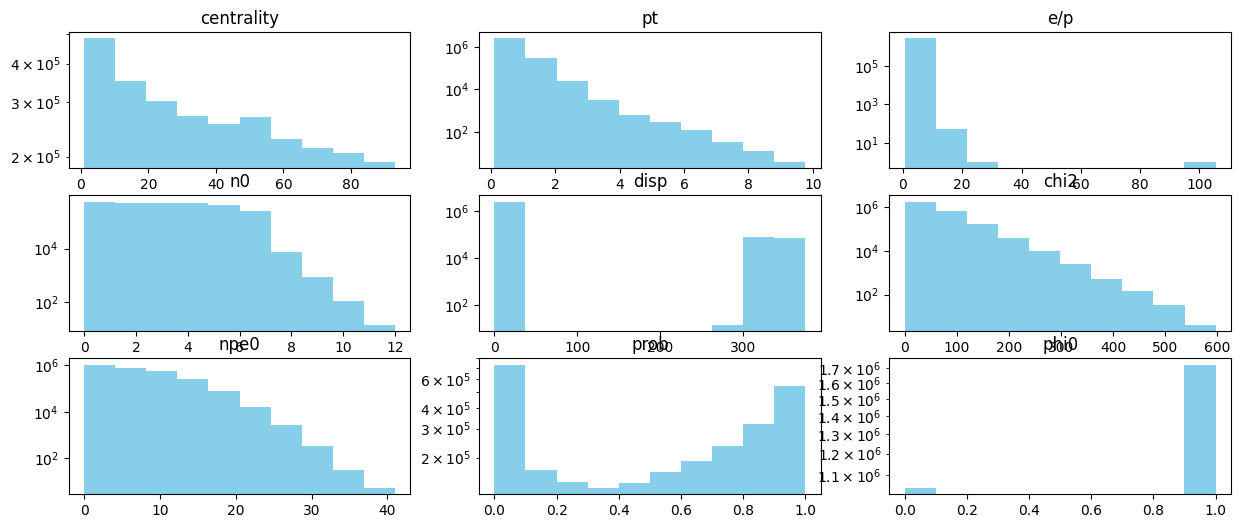

In [13]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [14]:
from sklearn.preprocessing import OneHotEncoder

def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # удаляем impressions
    data = data.drop('impressions', axis = 1)
    
    # создаем фичи от времени
    data.date_time = pd.to_datetime(data.date_time)
    data['day'] = data['date_time'].dt.weekday
    data['hour'] = data['date_time'].dt.hour
    
    # строим графики зависимости количества кликов от дня недели и часа
    data[data['clicks'] > 0].sort_values(by = ['day']).groupby(['day'])['clicks'].sum().plot.barh(title='Clicks by weekday')
    plt.show()
    data[data['clicks'] > 0].sort_values(by = ['hour']).groupby(['hour'])['clicks'].sum().plot.barh(title='Clicks by hour')

    # добавляем интерсекции между часом и днем недели 
    data['hour_day'] = data['day'].astype(str) + ' ' + data['hour'].astype(str)
    data['hour_day'] = pd.factorize(data['hour_day'])[0]
    
    # выделяем редкие zone id в категорию -1
    zone_id_counts = data['zone_id'].value_counts()
    idxs = zone_id_counts[zone_id_counts < 10].index
    
    data.loc[data['zone_id'].isin(idxs), 'zone_id'] = -1
    
    # выделяем редкие os_id в категорию 7
    data.loc[data['os_id'] > 7, 'os_id'] = 7
    
    # преобразовываем campaign clicks в бинарную фичу
    data['before_clicks'] = data['campaign_clicks'] > 0
    data['before_clicks'] = data['before_clicks'].astype('int64')
    
    # делим выборку на train и test
    data = data.sort_values(by='date_time', ignore_index=True)
    cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    y = data['clicks']
    data = data.drop(columns = ['banner_id', 'clicks', 'campaign_clicks', 'date_time'])
    data_train, data_test = data.iloc[:cut_off_test, :], data.iloc[cut_off_test:, :]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    enc.fit(data_train)
    transformed_train = enc.transform(data_train)
    transformed_test = enc.transform(data_test)
    
    return transformed_train, transformed_test, y_train, y_test,cut_off_val

In [15]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # делим выборку на train и test
    #data = data.sort_values(by='date_time', ignore_index=True)
    #cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    #cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    cut_off_val =  int (data.shape[0]/3)
    cut_off_test = int (data.shape[0]/3*2 + 1)

    print(cut_off_val,cut_off_test)

    y = data['phi0']
    data = data.drop(columns = ['phi0'])
    data_train, data_test = data[:cut_off_test], data[cut_off_test:]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    #enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    #enc.fit(data_train)
    #transformed_train = enc.transform(data_train)
    #transformed_test = enc.transform(data_test)
    
    return data_train, data_test, y_train, y_test,cut_off_val

In [16]:
transformed_train_all, transformed_test, y_train_all, y_test, cut_off_val = feature_engineering(data)

922867 1845735


In [17]:
transformed_test

,centrality,pt,e/p,n0,disp,chi2,npe0,prob,disp2,n0*disp,...,e/p*prob,n0*prob,prob-1,e/p*pt,n0*pt,n0-2,e/p-0.8,pt-1,pt2,centrality-2
99190,19,0.938965,1.800781,3,5.734375,165.875000,2,0.000010,32.883057,0.148492,...,1.044712e-05,0.001010,1.000000,0.970517,0.969518,3.0,1.001563,1.065003,0.881655,0.002770
357755,52,0.742188,0.971191,2,3.953125,37.375000,2,0.756836,15.627197,0.000000,...,2.218021e-02,0.000000,2.027876,0.025248,0.000000,0.0,0.029306,1.347368,0.550842,0.000370
21778,53,0.429688,0.726074,2,6.972656,24.578125,5,0.638672,48.617935,0.000000,...,-3.490355e-03,0.000000,1.663578,-0.003582,0.000000,0.0,-0.005465,2.327273,0.184631,0.000356
251007,27,0.814941,0.650879,1,4.785156,31.703125,0,0.000747,22.897720,-0.172856,...,-1.660504e-05,-0.001747,1.000369,-0.020074,-0.903295,-1.0,-0.022237,1.227082,0.664129,0.001372
449497,25,0.300293,1.080078,5,2.208984,29.203125,13,0.992188,4.879612,0.934875,...,7.783091e-02,2.979563,11.306475,0.042986,1.646705,15.0,0.078444,3.330081,0.090176,0.001600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498035,1,0.708984,1.018555,4,0.744629,56.093750,7,0.298828,0.554472,1.146376,...,1.427387e-02,0.599656,1.194221,0.040220,1.685211,8.0,0.047766,1.410468,0.502659,1.000000
1470540,51,0.471191,1.986328,3,2.898438,87.187500,6,0.000132,8.400940,0.256513,...,1.860593e-04,0.001132,1.000061,0.966069,0.687162,3.0,1.407374,2.122280,0.222021,0.000384
199623,33,0.304688,0.948730,5,1.184570,15.531250,9,0.967285,1.403207,1.373268,...,2.139708e-02,2.904855,5.527913,0.012210,1.658670,15.0,0.022121,3.282051,0.092834,0.000918
333969,11,1.226562,0.796875,2,4.664062,31.937500,1,0.000786,21.753479,0.000000,...,-7.678755e-09,0.000000,1.000388,-0.000011,0.000000,0.0,-0.000010,0.815287,1.504456,0.008264


In [18]:
transformed_train, transformed_val = transformed_train_all[:cut_off_val], transformed_train_all[cut_off_val:]
y_train, y_val = y_train_all[:cut_off_val], y_train_all[cut_off_val:]

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, f1_score

In [20]:
def create_model(C):
    clf = LogisticRegression(solver='newton-cholesky', max_iter=10000, C=C, verbose=1)
    return clf

Возьмем логистическую регрессию, в качестве солвера берем newton-cholesky, так как в документации sklearn сказано, что он лучше работает с one-hot-encoded фичами.

# Cross Validation

In [21]:
def cv(data_train: pd.DataFrame, data_val, y_train, y_val):
    best_score = 0.5
    best_C = 0.1
    for C in [0.0001,0.001,0.01,0.05,0.1,1,10,100,1000,10000]:
        clf = create_model(C)
        clf.fit(data_train, y_train)
        y_pred_probs = clf.predict_proba(data_val)
        score = roc_auc_score(y_val, y_pred_probs[:, 1])
        if score > best_score:
            best_score = score
            best_C = C
            print("localy best C:", best_C)       
    print("the best C:", best_C)        
    best_model = create_model(best_C)
    return best_model

In [22]:
print(transformed_val.shape,y_val.shape)

(922868, 22) (922868,)


In [23]:
clf = cv(transformed_train, transformed_val, y_train, y_val)

Newton iter=1
  Check Convergence
    1. max |gradient| 700.4954674028623 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 292.7765923708139 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 132.54376888118355 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 36.04071057537774 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 2.460797187342233 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 0.009817237176199325 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 1.409537099561542e-07 <= 0.0001
    2. Newton decrement 2.3738824601513844e-12 <= 0.0001
  Solver did converge at loss = 0.3286551392109005.
localy best C: 0.0001
Newton iter=1
  Check Convergence
    1. max |gradient| 723.555141541512 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 279.16310021306856 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 109.43503870211806 <= 0.0001
Newton iter=4
  Chec

Обучаем лучшую модель заново на тренировочном и валидационном датасете.

In [24]:
clf.fit(transformed_train_all, y_train_all)

Newton iter=1
  Check Convergence
    1. max |gradient| 721.490756392407 <= 0.0001
Newton iter=2
  Check Convergence
    1. max |gradient| 259.4355540949761 <= 0.0001
Newton iter=3
  Check Convergence
    1. max |gradient| 88.51337696707702 <= 0.0001
Newton iter=4
  Check Convergence
    1. max |gradient| 21.317394255756625 <= 0.0001
Newton iter=5
  Check Convergence
    1. max |gradient| 1.5958140796366163 <= 0.0001
Newton iter=6
  Check Convergence
    1. max |gradient| 0.011281996200189973 <= 0.0001
Newton iter=7
  Check Convergence
    1. max |gradient| 3.0574500315922074e-06 <= 0.0001
    2. Newton decrement 1.761750184943456e-09 <= 0.0001
  Solver did converge at loss = 0.29479266766115775.


LogisticRegression(C=0.1, max_iter=10000, solver='newton-cholesky', verbose=1)

# Model Evaluation

In [25]:
y_pred_probs = clf.predict_proba(transformed_test)
y_pred = clf.predict(transformed_test)

In [26]:
clf

LogisticRegression(C=0.1, max_iter=10000, solver='newton-cholesky', verbose=1)

Посчитаем скоры (ROC AUC, log loss и f1 score).

log loss: 0.29359945282766053
roc auc: 0.9454884920953619
f1 score: 0.8989780263619398


Text(0.5, 1.0, 'ROC AUC Curve')

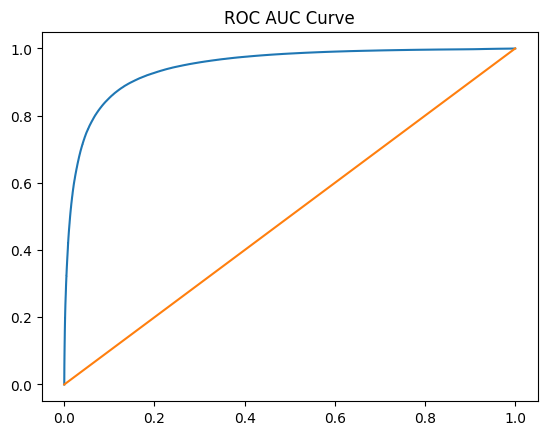

In [27]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score

print('log loss:', log_loss(y_test, y_pred_probs))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.title('ROC AUC Curve')

Сравним со скорами из бейзлайна. Бейзлайн: предсказываем все нулями

In [28]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.6624707539006307


Видим, что наша модель обгоняет бейзлайн по метрикам ROC AUC и Log Loss.

In [29]:
i = 7700
print(round(tpr[i],3),round(fpr[i]/tpr[i],4))
print(thresholds[i],fpr[i],tpr[i])
print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.483 0.0247
0.9611831918453346 0.011897264233148418 0.48261640644017106
671.8779222247495 1392.157235558134


In [30]:
print(clf.intercept_)
for keff in clf.coef_[0]:
    print(keff)
output_data = [clf.intercept_,clf.coef_[0]]
with open("output/keffs.txt", "w") as txt_file:
    for line in output_data:
        txt_file.write("".join(str(line)) + "\n")

[-2.12628313]
0.0216317449022171
3.150286279858426
3.1138671144625842
-2.8687541262184126
-0.1925774576684748
-0.00026695743812447427
0.2337326482303475
2.4487368175806976
0.0004956772170501978
-9.277503735338401
13.019511733999932
5.6803500379626e-06
-2.036793535551633
0.06944832256890189
-0.005080047657653464
-2.7271418618161434
0.09461654916592667
-0.19774336101697967
0.4065094463392673
0.6217303799559468
-0.585456113518538
-0.34565339042962234


In [31]:
def answer(centrality,pt,ep,n0,disp,chi2,npe0,prob):
    ans = clf.coef_[0][0]*centrality+clf.coef_[0][1]*pt+clf.coef_[0][2]*ep+clf.coef_[0][3]*n0+\
        clf.coef_[0][4]*disp+clf.coef_[0][5]*chi2+clf.coef_[0][6]*npe0+clf.coef_[0][7]*prob+clf.intercept_[0]
    return ans

In [32]:
kek_data = data
kek_data = kek_data.drop(columns = ['phi0'])
proba_loc = clf.predict_proba(kek_data)
print(proba_loc[0][1])

0.9757702904869122


In [33]:
mycute,mycuth, AIcute, AIcuth = 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = data.reset_index()  # make sure indexes pair with number of rows

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>100000: break
    centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 = row['centrality'], row['pt'], row['e/p'], row['n0'], row['disp'], row['chi2'], row['npe0'], row['prob'], row['phi0']
    if pt<0.4 or centrality<0: continue
    if ep>0.8 and n0>=2+disp**2/8 and prob>0.01 and chi2/(npe0+1e-4)<10: 
        if phi0: mycute+=1
        else: mycuth+=1
    if proba_loc[counter][1]>thresholds[i]: 
        if phi0: AIcute+=1
        else: AIcuth+=1
    if phi0: norm_e+=1
    else: norm_h+=1
    if counter<10: 
        print(proba_loc[counter],answer(centrality,pt,ep,n0,disp,chi2,npe0,prob))
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )

[0.02422971 0.97577029] -3.923556950542579
[0.95892581 0.04107419] -1.1104772951722868
[0.00971984 0.99028016] 0.6385417068990398
[0.10451688 0.89548312] -6.2873868585099615
[0.22252389 0.77747611] 0.0837855721398717
[0.38167466 0.61832534] -8.021573782470904
[0.24321826 0.75678174] -2.689565116939576
[0.04174081 0.95825919] -7.074902716703464
[0.6508431 0.3491569] -1.772178647550344


In [34]:
print(norm_e, norm_h,round(mycute/norm_e,3),round(mycuth/norm_h,3), round(AIcute/norm_e,3), round(AIcuth/norm_h,3), round(AIcuth/AIcute/norm_h*norm_e,3),round(fpr[i]/tpr[i],3))

55768 35651 0.517 0.013 0.49 0.011 0.021 0.025


In [35]:
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3))

1.197 0.947 0.791
